 # Notebook 01 — Density-weighted Growth Rate & Increment Comparison



 Replaces `density_weighing_and_increment_detection (1).py`.



 Workflow:

 1. Mount Drive and inject repo into `sys.path`

 2. Load the four post-stain microCT density curves

 3. Average curves and compute density-weighted time axis

 4. Detect automated increments from Curve 6

 5. DTW-align derived vs manual increments and fit OLS



 Run cells top-to-bottom. Edit the **User Config** cell to match your

 Drive layout before running.

 ## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


 ## Inject repo into Python path

In [5]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 56.7 MB/s eta 0:00:00


In [6]:
import sys

# Edit REPO_PATH if you cloned the repo to a different location inside MyDrive
REPO_PATH = '/content/rhodopipeline'

if REPO_PATH not in sys.path:
    sys.path.insert(0, REPO_PATH)

import rhodopipeline  # verify the package loads
print('rhodopipeline imported successfully')


rhodopipeline imported successfully


 ## Imports

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from rhodopipeline.growth import (
    load_density_curves,
    average_curves,
    compute_density_weighted_time,
    detect_curve6_increments,
    align_and_regress_increments,
)
from rhodopipeline.config import CONFIG


 ## User Config



 Override `BASE_PATH`, `OUTPUT_DIR`, `START_DATE`, or `END_DATE` here if

 your Drive paths differ from the defaults in `config.py`.

In [8]:
BASE_PATH  = CONFIG['paths']['microct_base']
OUTPUT_DIR = CONFIG['paths']['output_dir']

START_DATE = datetime(2024, 3, 13, 12)   # alizarin stain
END_DATE   = datetime(2024, 7, 23, 12)   # microCT scan

print(f'BASE_PATH  : {BASE_PATH}')
print(f'OUTPUT_DIR : {OUTPUT_DIR}')
print(f'Growth window: {START_DATE.date()} → {END_DATE.date()}')


BASE_PATH  : /content/drive/MyDrive/PhD data/microCT/measurement data/
OUTPUT_DIR : /content/drive/MyDrive/PhD data/Rhodolith papers/
Growth window: 2024-03-13 → 2024-07-23


 ## Load and inspect density curves

In [9]:
density_curves = load_density_curves(BASE_PATH)

for i, df in enumerate(density_curves, 1):
    print(f'Curve {i}: {len(df)} rows  |  '
          f'x range [{df["x"].min():.1f}, {df["x"].max():.1f}]  |  '
          f'y range [{df["y"].min():.4f}, {df["y"].max():.4f}]')


Curve 1: 919 rows  |  x range [0.0, 1824.2]  |  y range [29311.2000, 41401.7000]
Curve 2: 888 rows  |  x range [0.0, 1959.7]  |  y range [29127.6000, 42544.4000]
Curve 3: 968 rows  |  x range [0.0, 2038.5]  |  y range [31104.8000, 44449.3000]
Curve 4: 981 rows  |  x range [0.0, 2418.1]  |  y range [29877.9000, 43961.3000]


 ## Average density profile

In [10]:
average_density = average_curves(density_curves, n_points=1000)
print(average_density.describe())


                 x             y        y_std
count  1000.000000   1000.000000  1000.000000
mean   1209.025000  35725.975972  2367.547517
std     699.078916   1660.093064   876.693426
min       0.000000  31739.548463   173.221615
25%     604.512500  34474.221271  1752.272619
50%    1209.025000  35800.774103  2283.113330
75%    1813.537500  36809.956194  3065.314827
max    2418.050000  39227.840265  4352.341333


 ## Density-weighted time axis

In [11]:
average_growth_rates = compute_density_weighted_time(
    average_density[['x', 'y']],
    START_DATE,
    END_DATE,
)

print(f'Growth-rate DataFrame: {len(average_growth_rates)} rows')
print(average_growth_rates.head())

# Save for downstream use
out_path = OUTPUT_DIR + 'average_growth_rates.csv'
average_growth_rates.to_csv(out_path, index=False)
print(f'\nSaved to {out_path}')


Growth-rate DataFrame: 999 rows
          x       density        dt                   DateTime          v
0  0.000000  39131.575000  0.144729 2024-03-13 12:00:00.000000  16.724198
1  2.420470  39227.840265  0.145085 2024-03-13 15:28:24.554925  16.683156
2  4.840941  39207.825318  0.145011 2024-03-13 18:57:19.871563  16.691673
3  7.261411  39098.253389  0.144605 2024-03-13 22:26:08.792394  16.738451
4  9.681882  38962.607267  0.144104 2024-03-14 01:54:22.699347  16.796725

Saved to /content/drive/MyDrive/PhD data/Rhodolith papers/average_growth_rates.csv


 ## Plot growth rate over time

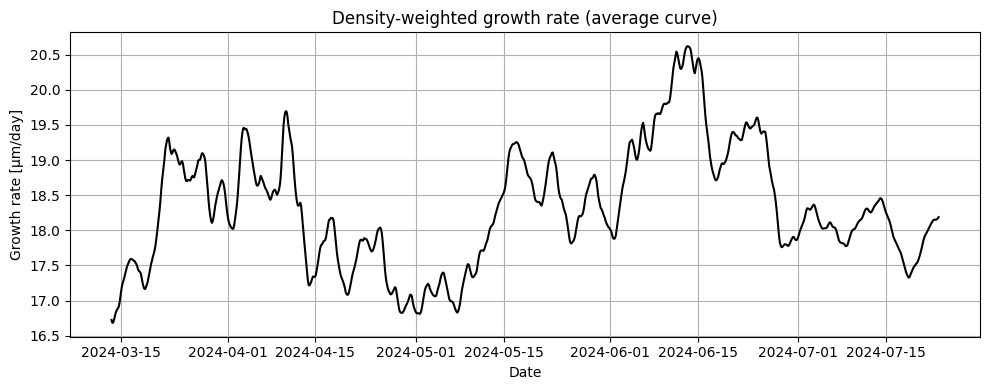

In [12]:
plt.figure(figsize=(10, 4))
plt.plot(average_growth_rates['DateTime'], average_growth_rates['v'], '-', color='k')
plt.xlabel('Date')
plt.ylabel('Growth rate [µm/day]')
plt.title('Density-weighted growth rate (average curve)')
plt.grid(True)
plt.tight_layout()
plt.show()


 ## Load manual increment data and detect Curve 6 increments

In [13]:
inc_path = BASE_PATH + 'afe5-1 microct data.xlsx'
df_incwidth = pd.read_excel(inc_path)
df_incwidth.drop(
    columns=[c for c in df_incwidth.columns if str(c).startswith('Unnamed')],
    inplace=True,
    errors='ignore',
)
df_incwidth.columns = [c.replace(' ', '') for c in df_incwidth.columns]

print(f'Columns: {list(df_incwidth.columns)}')

derived_increments, derived_positions = detect_curve6_increments(df_incwidth)

# Manual increments
increments_6      = df_incwidth['curve6'].values
manual_mask       = ~np.isnan(increments_6)
manual_increments = increments_6[manual_mask]

print(f'\nDerived increments : {len(derived_increments)}')
print(f'Manual increments  : {len(manual_increments)}')


Columns: ['curve1', 'curve1x', 'curve1y', 'curve2', 'curve2x', 'curve2y', 'curve3', 'curve3x', 'curve3y', 'curve4', 'curve4x', 'curve4y', 'curve6', 'curve6x', 'curve6y', 'densitycode', 'curve7x', 'curve7y']

Derived increments : 78
Manual increments  : 102


 ## DTW alignment and OLS regression

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.587
Method:                 Least Squares   F-statistic:                     181.6
Date:                Wed, 25 Feb 2026   Prob (F-statistic):           3.51e-26
Time:                        13:00:16   Log-Likelihood:                -465.14
No. Observations:                 128   AIC:                             934.3
Df Residuals:                     126   BIC:                             940.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.9720      1.550      5.145      0.0

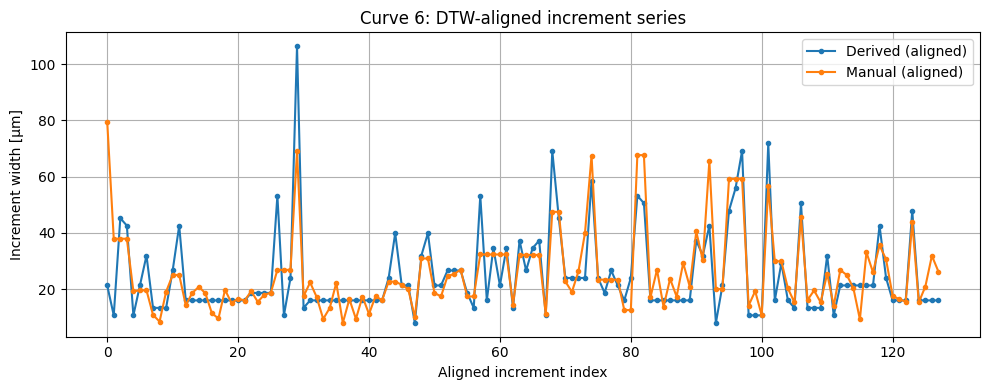

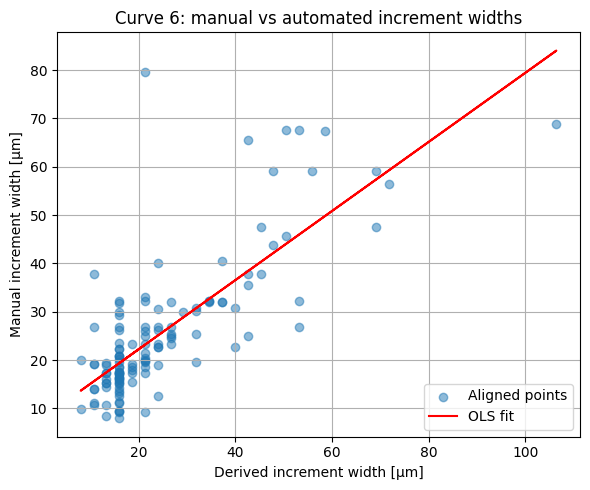

In [14]:
if len(derived_increments) == 0 or len(manual_increments) == 0:
    print('Skipping DTW: one sequence is empty.')
else:
    model, derived_aligned, manual_aligned = align_and_regress_increments(
        derived_increments, manual_increments
    )
    print(model.summary())

    # Plot aligned sequences
    plt.figure(figsize=(10, 4))
    plt.plot(derived_aligned, '.-', label='Derived (aligned)')
    plt.plot(manual_aligned,  '.-', label='Manual (aligned)')
    plt.xlabel('Aligned increment index')
    plt.ylabel('Increment width [µm]')
    plt.title('Curve 6: DTW-aligned increment series')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # OLS scatter
    import statsmodels.api as sm
    mask_clean = ~np.isnan(derived_aligned) & ~np.isnan(manual_aligned)
    X_clean    = derived_aligned[mask_clean]
    y_clean    = manual_aligned[mask_clean]
    X_mat      = sm.add_constant(X_clean.reshape(-1, 1))

    plt.figure(figsize=(6, 5))
    plt.scatter(X_clean, y_clean, alpha=0.5, label='Aligned points')
    plt.plot(X_clean, model.predict(X_mat), color='red', label='OLS fit')
    plt.xlabel('Derived increment width [µm]')
    plt.ylabel('Manual increment width [µm]')
    plt.title('Curve 6: manual vs automated increment widths')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
